In [1]:
import os
import numpy as np
import torch
import pytorch_lightning as pl
import torchmetrics
from dvc.api import params_show
from dvclive import Live
from dvclive.lightning import DVCLiveLogger

/Users/dave/miniforge3/envs/dvc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = "fra.txt"
seed = 423
num_samples = 1000
batch_size = 64

In [3]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")[:-1]
np.random.seed(seed)
np.random.shuffle(lines)
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters)) + ["\t", "\n"]
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length), dtype=int
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length), dtype=int
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length), dtype=int
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t] = input_token_index[char]
    encoder_input_data[i, t + 1 :] = input_token_index[" "]
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] = target_token_index[char]
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1] = target_token_index[char]
    decoder_input_data[i, t + 1 :] = target_token_index[" "]
    decoder_target_data[i, t:] = target_token_index[" "]

Number of samples: 1000
Number of unique input tokens: 65
Number of unique output tokens: 86
Max sequence length for inputs: 102
Max sequence length for outputs: 121


In [4]:
# Define the model 
class LSTMSeqToSeq(pl.LightningModule):
    def __init__(self, latent_dim=8, optim_params={}):
        super().__init__()
        self.save_hyperparameters()
        self.encoder_embedding = torch.nn.Embedding(num_encoder_tokens, self.hparams.latent_dim)
        self.encoder = torch.nn.LSTM(self.hparams.latent_dim, self.hparams.latent_dim, batch_first=True)
        self.decoder_embedding = torch.nn.Embedding(num_decoder_tokens,
                self.hparams.latent_dim)
        self.decoder = torch.nn.LSTM(self.hparams.latent_dim, self.hparams.latent_dim, batch_first=True)

        self.out = torch.nn.Linear(self.hparams.latent_dim, num_decoder_tokens)
        self.acc = torchmetrics.classification.MulticlassAccuracy(
                num_decoder_tokens, average="macro")

    def forward(self, x_encoder, x_decoder):
        encoder_embedded = self.encoder_embedding(x_encoder)
        encoder_outputs, (state_h, state_c) = self.encoder(encoder_embedded)
        decoder_embedded = self.decoder_embedding(x_decoder)
        # We discard `encoder_outputs` and only keep the states.
        decoder_outputs, (_, _) = self.decoder(decoder_embedded, (state_h, state_c))
        out = self.out(decoder_outputs)
        return out

    def training_step(self, batch, batch_idx):
        (x_encoder, x_decoder), y = batch
        out = self(x_encoder, x_decoder)
        # Reshape each step
        y = y.flatten()
        out = out.flatten(end_dim=1)
        # Log metrics
        loss = torch.nn.functional.cross_entropy(out, y)
        acc = self.acc(out, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        (x_encoder, x_decoder), y = batch
        out = self(x_encoder, x_decoder)
        # Reshape each step
        y = y.flatten()
        out = out.flatten(end_dim=1)
        # Log metrics
        loss = torch.nn.functional.cross_entropy(out, y)
        acc = self.acc(out, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.RMSprop(self.parameters(), **self.hparams.optim_params)
        return optimizer

In [5]:
# load the data
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encoder_input_data, decoder_input_data,
            decoder_target_data):
        self.encoder_input_data = encoder_input_data
        self.decoder_input_data = decoder_input_data
        self.decoder_target_data = decoder_target_data

    def __len__(self):
        return len(self.encoder_input_data)

    def __getitem__(self, idx):
        return (self.encoder_input_data[idx], self.decoder_input_data[idx]), \
               self.decoder_target_data[idx]


combined_data = CustomDataset(encoder_input_data, decoder_input_data, decoder_target_data)
train_len = int(len(combined_data)*0.8)
val_len = len(combined_data) - train_len
train, val = torch.utils.data.random_split(combined_data, [train_len, val_len],
        generator=torch.Generator().manual_seed(seed))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size)

# DVC Report

params.yaml

|   latent_dim | optim_params                   |
|--------------|--------------------------------|
|           32 | {'lr': 0.01, 'momentum': 0.01} |

metrics.json

|   val.loss |   val.acc |   epoch |   step |   train.epoch.loss |   train.epoch.acc |   train.step.loss |   train.step.acc |
|------------|-----------|---------|--------|--------------------|-------------------|-------------------|------------------|
|   0.625004 |  0.106842 |       9 |    129 |           0.580468 |          0.106762 |          0.578803 |        0.0988849 |

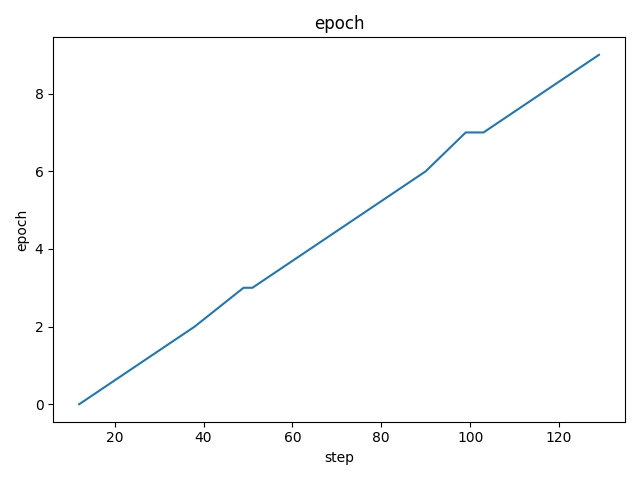

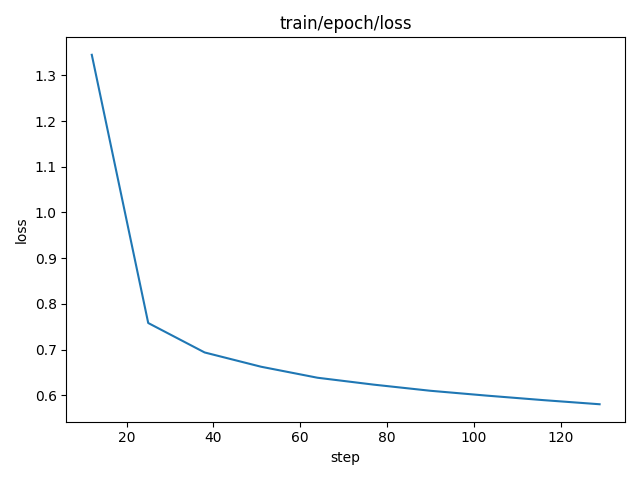

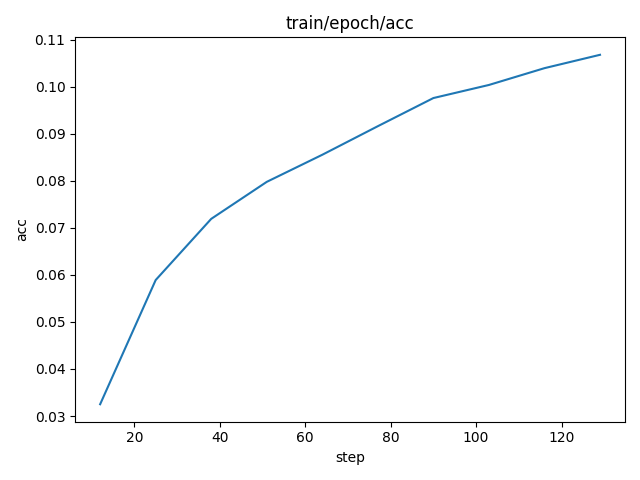

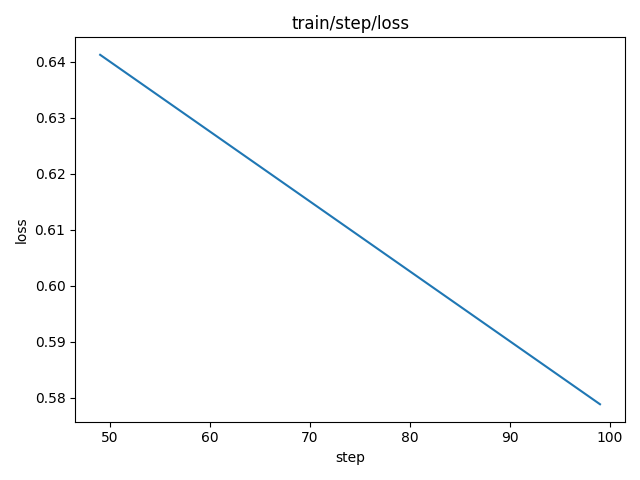

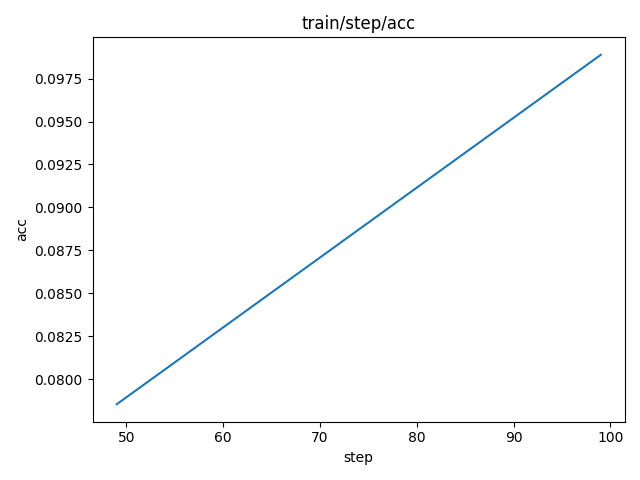

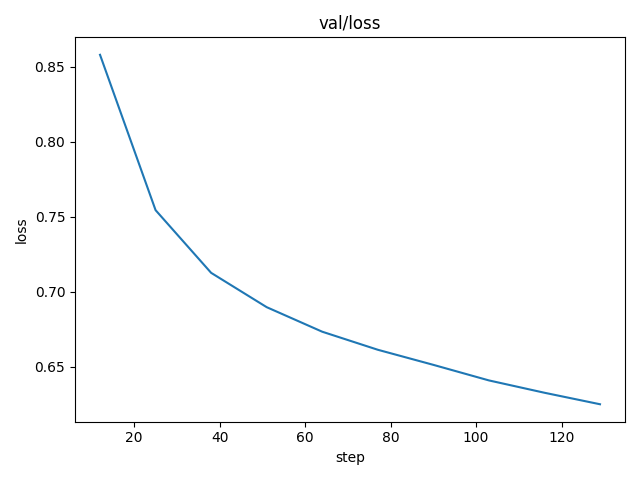

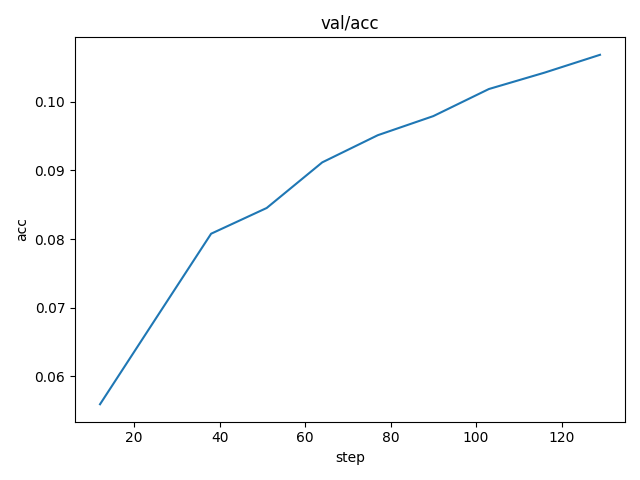


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/dave/miniforge3/envs/dvc/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/dave/miniforge3/envs/dvc/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /Users/dave/Code/lstm_seq2seq/DvcLiveLogger/dvclive_run/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name              | Type               | Params
---------------------------------------------------------
0 | encoder_embedding | Embedding          | 2.1 K 
1 | encoder           | LSTM               | 8.4 K 
2 | decoder_embedding | Embedding          | 2.8 K 
3 | decoder           | 

Sanity Checking: 0it [00:00, ?it/s]

/Users/dave/miniforge3/envs/dvc/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/dave/miniforge3/envs/dvc/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/dave/miniforge3/envs/dvc/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  76%|███████▋  | 13/17 [00:00<00:00, 21.32it/s, loss=1.32, v_num=_run]
Validation: 0it [00:00, ?it/s]
Epoch 1:  76%|███████▋  | 13/17 [00:01<00:00, 12.97it/s, loss=0.802, v_num=_run]
Validation: 0it [00:00, ?it/s]
Epoch 2:  76%|███████▋  | 13/17 [00:01<00:00, 10.97it/s, loss=0.703, v_num=_run]
Validation: 0it [00:00, ?it/s]
Epoch 3:  76%|███████▋  | 13/17 [00:01<00:00,  8.00it/s, loss=0.665, v_num=_run]
Validation: 0it [00:00, ?it/s]
Epoch 4:  76%|███████▋  | 13/17 [00:01<00:00, 12.21it/s, loss=0.64, v_num=_run] 
Validation: 0it [00:00, ?it/s]
Epoch 5:  76%|███████▋  | 13/17 [00:01<00:00, 11.41it/s, loss=0.623, v_num=_run]
Validation: 0it [00:00, ?it/s]
Epoch 6:  76%|███████▋  | 13/17 [00:01<00:00, 11.77it/s, loss=0.609, v_num=_run]
Validation: 0it [00:00, ?it/s]
Epoch 7:  76%|███████▋  | 13/17 [00:01<00:00,  8.33it/s, loss=0.598, v_num=_run]
Validation: 0it [00:00, ?it/s]
Epoch 8:  76%|███████▋  | 13/17 [00:01<00:00, 12.12it/s, loss=0.588, v_num=_run]
Validation: 0it [00:00, 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 17/17 [00:02<00:00,  6.57it/s, loss=0.579, v_num=_run]


output 'model/model.ckpt' does not exist


In [6]:
# train the model
arch = LSTMSeqToSeq(
    latent_dim=32,
    optim_params={
        "lr": 0.01,
        "momentum": 0.01
    }
)

exp = Live("results", save_dvc_exp=True, report="notebook")
live = DVCLiveLogger(experiment=exp)

trainer = pl.Trainer(max_epochs=10, logger=[live])
trainer.fit(model=arch, train_dataloaders=train_loader,
        val_dataloaders=val_loader)

In [ ]:
# Setup optuna study
import optuna

def objective(trial):
    lr = trial.suggest_float('lr', 1e-3, 1e-2, log=True)
    momentum = trial.suggest_float('momentum', 0.0, 1.0)
    alpha = trial.suggest_float('alpha', 1 - 1e-2, 1)
    weight_decay = trial.suggest_float('weight_decay', 0.0, 0.1)

    arch = LSTMSeqToSeq(
        latent_dim=32,
        optim_params={
            "lr": lr,
            "momentum": momentum,
            "alpha": alpha,
            "weight_decay": weight_decay
        }
    )

    with Live("results", save_dvc_exp=True) as exp:
        live = DVCLiveLogger(experiment=exp)

        trainer = pl.Trainer(max_epochs=10, logger=[live])
        trainer.fit(model=arch, train_dataloaders=train_loader,
                val_dataloaders=val_loader)

        return live.experiment.summary["val"]["acc"]

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5